**Theory:**

Monochromatic light with wavelength $\lambda$ (wavenumber $k_0=2\pi/\lambda$) propagating through a medium with relative permeability $\epsilon(\mathbf{r})=\epsilon/\epsilon_0$ and suceptibility $\chi(\mathbf{r})=\epsilon(\mathbf{r})-1$ is described by the vectorial wave equation

$$\nabla^2\mathbf{E}(\mathbf{r})+k_0^2\epsilon(\mathbf{r})\mathbf{E}(\mathbf{r})=-\nabla[\mathbf{E}(\mathbf{r})\cdot\nabla\epsilon(\mathbf{r})]$$

We'll asume that $\epsilon(\mathbf{r})$ is slowly varying so we neglect the rhs of the equation. For light travelling predominantely along $\mathbf{e}_z$ the equation above can be written as

$$-\frac{\partial^2 E(\mathbf{r})}{\partial z^2}=(\nabla_{\perp}^2+k_0^2)E(\mathbf{r})+k_0^2\chi(\mathbf{r})E(\mathbf{r})$$, 

which has the solution

$$E(\mathbf{r}+\Delta z\mathbf{e}_z)=\exp\left[\pm i\Delta z\sqrt{\nabla_{\perp}^2+k_0^2+k_0^2\chi(\mathbf{r})}\right]E(\mathbf{r}$$

If we consider a field that can be written as $E(\mathbf{r}) = exp (ik_0z)E'(\mathbf{r})$ where $E'(\mathbf{r})$ is a slowly varying envelope along $\mathbf{e}_z$, we get the paraxial wave equation

$$-2ik_0\frac{\partial E'(\mathbf{r})}{\partial z} = \nabla_\perp^2 E'(\mathbf{r})+k_0^2\chi(\mathbf{r})E'(\mathbf{r})$$

Notice how the equation looks a lot like the Schrödinger equation with $E'\leftrightarrow \psi$, $z \leftrightarrow t$ and $\nabla_\perp \leftrightarrow \nabla$. The evolution of $E'$ can be partitioned into a spectral part $\mathbf{\tilde P}(\mathbf{k}_{2D},\Delta z)$ and a coordinate part $\mathbf{Q}(\Delta z)$ with 

$$\mathbf{\tilde P}(\mathbf{k}_{2D},\Delta z)=\exp\left(-i\frac{k_{2D}^2}{2k_0}\Delta z\right),$$

$$\mathbf{Q}(\Delta z)=\exp\left(i\frac{k_0}{2}\int_z^{z+\Delta z}\chi(\mathbf{r})dz'\right).$$

I will evolve $E'$ numerically using a Fourier split-step method

In [47]:

import matplotlib.pyplot as plt
import numpy as np


# Constants:
pi = np.pi
hbar = 1.054571726e-34                        # Reduced Planck's constant
wavelength = 780e-9                           # Imaging wavelength
k0 = 2 * pi / wavelength
um = 1e-6
cm = 1e-2

# Space:
nx = 256
x_max = 100 * um
x = np.linspace(-x_max, x_max, nx, endpoint=False)
dx = x[1] - x[0]

# Fourier space:
k = 2*pi*np.fft.fftshift(np.fft.fftfreq(nx, d=dx))

k_2D = np.empty([nx,nx])

for i in range(nx):
    for j in range(nx):
        k_2D[i,j] = np.sqrt(k[i]**2 + k[j]**2)


# Wavenumber of nyquist mode - shortest wavenumber we can resolve:
k_nyquist = pi/dx

# The kinetic energy operator in Fourier space
K = k_2D**2 / (2 * k0)

def chi(delta, E, rho):
    
    """
    I: intensity in units of Isat
    delta: detuning in units of linewidth
    rho: density
    """
    
    k0 = 2 * np.pi / 780e-9
    sigma0 = 6 * np.pi / k0 **2
    
    chi = sigma0 / k0 * (1.0j - 2 * delta) / (1 + np.abs(E)**2 + 2 * delta ** 2) * rho
    
    return chi

def split_step2(E, dz, chi_val):

    """"Evolve E in time from z to z + dz using one
    step of the second order Fourier split-step method"""

    E *= np.exp(-1j / (2 * k0) * chi_val * dz/2)

    f_E = np.fft.fftshift(np.fft.fft2(E))
    f_E *= np.exp(-1j * K * dz)
    E = np.fft.ifft2(f_E)

    E *= np.exp(-1j / (2 * k0) * chi_val * dz/2)

    return E

def TF_3D(xyz_vals, n0, x0, y0, z0, rx, ry, rz):
    

    condition = (1 - (xyz_vals[0]-x0) **2 / rx **2 - 
                (xyz_vals[1]-y0) **2 / ry **2 - 
                (xyz_vals[2]-z0) **2 / rz ** 2)
    condition[condition <= 0.0] = 0.0
    
    condition *= n0
    
    return condition

def gaussian_2D(xy_vals, bkg, amp, x0, y0, sigmax, sigmay) :

    gauss2D = bkg + amp*np.exp(-1*(xy_vals[0]-x0)**2/(2*sigmax**2)
                                -1*(xy_vals[1]-y0)**2/(2*sigmay**2))
    
    
    return gauss2D


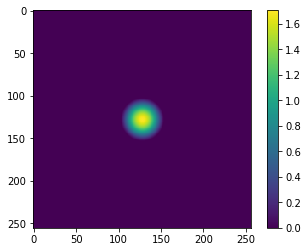

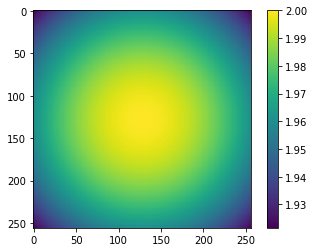

In [48]:
#ok, let's make a BEC
# consider density of 10^13 cm^-3
xyz_vals = np.meshgrid(x,x,x)
r_tf = 20 * um
n0 = 10 ** 13 / cm ** 3
TF = TF_3D(xyz_vals, 0.1, 0, 0, 0, r_tf, r_tf, r_tf/2)

plt.imshow(TF.sum(axis=2))
plt.colorbar()
plt.show()

#and a probe... how intense should it be?
xy_vals = np.meshgrid(x,x)
sigma = 500 * um
probe = gaussian_2D(xy_vals, 0, 2, 0, 0, sigma, sigma)
plt.imshow(probe)
plt.colorbar()
plt.show()

In [49]:
delta = 0.0
E0 = np.array(probe, dtype ='complex')

for i in range(nx):
    if i == 0:
        E = E0
    rho = TF[:,:,i]
    chi_TF = chi(delta, E, rho)
    E_new = split_step2(E, dx, chi_TF)
    E = E_new


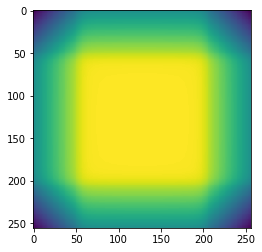

In [50]:
I_atoms = np.abs(E_new) ** 2
I_probe = np.abs(E0) ** 2

plt.imshow(np.log(I_probe/I_atoms))

(256,)

In [27]:
k.shape

(256,)

In [30]:
abs_k_2D

[2.6148053770258587e+26,
 2.5741086380645798e+26,
 2.5337310892128004e+26,
 2.493672730470522e+26,
 2.4539335618377442e+26,
 2.414513583314466e+26,
 2.375412794900688e+26,
 2.33663119659641e+26,
 2.2981687884016337e+26,
 2.2600255703163563e+26,
 2.222201542340579e+26,
 2.1846967044743023e+26,
 2.1475110567175266e+26,
 2.1106445990702504e+26,
 2.0740973315324737e+26,
 2.037869254104198e+26,
 2.001960366785423e+26,
 1.9663706695761476e+26,
 1.931100162476372e+26,
 1.8961488454860974e+26,
 1.8615167186053232e+26,
 1.8272037818340486e+26,
 1.7932100351722742e+26,
 1.75953547862e+26,
 1.726180112177227e+26,
 1.6931439358439528e+26,
 1.6604269496201802e+26,
 1.6280291535059068e+26,
 1.5959505475011342e+26,
 1.5641911316058612e+26,
 1.5327509058200894e+26,
 1.5016298701438169e+26,
 1.4708280245770455e+26,
 1.4403453691197732e+26,
 1.4101819037720019e+26,
 1.3803376285337307e+26,
 1.3508125434049597e+26,
 1.321606648385689e+26,
 1.2927199434759184e+26,
 1.2641524286756482e+26,
 1.2359041039848

In [39]:
len(k) == nx

True

In [26]:
dx

3.9062499999999764e-07